### This notebook contains the codes to generate all the plots used in the manuscript.
### Author: Chop Yan Lee

In [2]:
import pandas as pd
import numpy as np
from pymol import cmd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as sp
import glob, os, json, pickle, sqlalchemy, db_utils
from sklearn.metrics import roc_curve, auc
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from statannotations.Annotator import Annotator
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1, 1)
global_color = 'tab:grey'
connect = db_utils.get_connection()
save_path= '/Volumes/imb-luckgr/projects/dmi_predictor/DMI_AF2_PRS/Plots/DMI_types_minimal/AF2_MMv2.2_v2.3_comparison/'

In [3]:
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,change_markersize=False):
    global global_fontsize
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both',labelsize=global_fontsize)
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both',labelsize=global_fontsize)
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
    if change_markersize:
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    plt.tick_params(axis= 'both', labelsize= global_fontsize)

In [4]:
def parse_prediction_name(prediction_name):
    """Parse out different components in the standard name for a minimal DMI prediction (e.g. run37_DEG_APCC_KENBOX_2_4GGD)

    Args:
        prediction_name (str): Name of the folder containing the AlphaFold predicted structure

    Returns:
        run_id (str): Run ID
        dmi_name (str): Name of DMI type
        pdb_id (str): PDB ID
    """
    splits = prediction_name.split('_')
    run_id = splits[0]
    dmi_name = '_'.join(splits[1:-1])
    pdb_id = splits[-1]
    return [run_id, dmi_name, pdb_id]

In [5]:
# Gather information of run37 which was predicted with template and without using precomputed msas
query = """select * from chopyan_db.AlphaFold_prediction_result
where run_id = 'run37' and project_name = 'AlphaFold_benchmark';"""
# read in processed info
run37 = pd.read_sql_query(query,con=connect)

run37[['run_id','dmi_name','pdb_id']] = run37.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                        axis=1,result_type='expand')
print(run37.shape)

# I also only work with the best model as selected by the least RMSD_all_atom_peptide per predicton,
# the de-duplication will filter for best model per prediction
run37 = run37.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name','chainA_length',
                                                                           'chainB_length'],keep='first').copy()
run37.reset_index(drop=True,inplace=True)
print(run37.shape)

run37.head()

(680, 29)
(136, 29)


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,dmi_name,pdb_id
0,AlphaFold_benchmark,run37_DEG_SIAH_1_2A25,run37,193,9,ranked_3,0.920907,96.165000,92.233334,95.023548,...,146,0.506651,0.787199,None,0.959,0.481,0.492,0.133,DEG_SIAH_1,2A25
1,AlphaFold_benchmark,run37_DOC_USP7_MATH_1_3MQS,run37,143,5,ranked_0,0.923664,98.181667,93.685999,96.859411,...,137,0.608205,0.795526,None,0.976,0.398,0.589,0.200,DOC_USP7_MATH_1,3MQS
2,AlphaFold_benchmark,run37_DOC_PP2B_PxIxI_1_4F0Z,run37,292,7,ranked_0,0.950851,97.779376,93.825715,96.576088,...,292,0.420731,0.811035,None,0.959,0.385,0.445,0.000,DOC_PP2B_PxIxI_1,4F0Z
3,AlphaFold_benchmark,run37_DEG_Kelch_Keap1_1_2FLU,run37,285,6,ranked_1,0.938596,98.748889,88.666667,96.228333,...,285,0.436000,0.914587,None,0.968,0.397,0.431,0.057,DEG_Kelch_Keap1_1,2FLU
4,AlphaFold_benchmark,run37_LIG_TRAF2_2_1CZY,run37,168,6,ranked_3,0.861203,97.032381,82.186666,93.733333,...,168,0.643906,0.914688,None,0.961,0.375,0.638,0.000,LIG_TRAF2_2,1CZY


In [6]:
# Gather information of run37 which was predicted with template and without using precomputed msas
query = """select * from chopyan_db.AlphaFold_prediction_result
where run_id = 'run48' and project_name = 'AlphaFold_benchmark';"""
# read in processed info
run48 = pd.read_sql_query(query,con=connect)

run48[['run_id','dmi_name','pdb_id']] = run48.apply(lambda x: parse_prediction_name(x['prediction_name']),
                                                                        axis=1,result_type='expand')
print(run48.shape)

# I also only work with the best model as selected by the least RMSD_all_atom_peptide per predicton,
# the de-duplication will filter for best model per prediction
run48 = run48.sort_values(['RMSD_all_atom_peptide'],ascending=True).drop_duplicates(subset=['dmi_name','chainA_length',
                                                                           'chainB_length'],keep='first').copy()
run48.reset_index(drop=True,inplace=True)
print(run48.shape)

run48.head()

(680, 29)
(136, 29)


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_align_resi_domain,RMSD_backbone_peptide,RMSD_all_atom_peptide,known_motif_plddt,DockQ,iRMS,LRMS,Fnonnat,dmi_name,pdb_id
0,AlphaFold_benchmark,run48_DOC_USP7_MATH_1_3MQS,run48,143,5,ranked_0,0.934844,98.136665,93.456000,96.759999,...,137,0.550012,0.670959,None,0.978,0.387,0.555,0.167,DOC_USP7_MATH_1,3MQS
1,AlphaFold_benchmark,run48_DEG_SPOP_SBC_1_3HQM,run48,137,5,ranked_4,0.922114,98.384000,93.250000,97.100500,...,132,0.776712,0.699910,None,0.969,0.327,0.844,0.037,DEG_SPOP_SBC_1,3HQM
2,AlphaFold_benchmark,run48_DEG_SIAH_1_2A25,run48,193,9,ranked_3,0.931102,96.314286,93.671111,95.521334,...,146,0.434531,0.731597,None,0.961,0.472,0.442,0.114,DEG_SIAH_1,2A25
3,AlphaFold_benchmark,run48_DOC_PP2B_PxIxI_1_4F0Z,run48,292,7,ranked_2,0.958944,98.275625,94.781430,97.212174,...,292,0.413751,0.787736,None,0.958,0.393,0.450,0.000,DOC_PP2B_PxIxI_1,4F0Z
4,AlphaFold_benchmark,run48_DOC_ANK_TNKS_1_3TWU,run48,160,8,ranked_0,0.934079,98.609412,94.977499,97.447200,...,160,0.614377,0.792328,None,0.979,0.372,0.620,0.083,DOC_ANK_TNKS_1,3TWU


In [7]:
df = pd.merge(run37,run48,how='inner',left_on=['dmi_name','pdb_id'],right_on=['dmi_name','pdb_id'],
         suffixes=['_run37','_run48'])
df

,project_name_run37,prediction_name_run37,run_id_run37,chainA_length_run37,chainB_length_run37,model_id_run37,model_confidence_run37,chainA_intf_avg_plddt_run37,chainB_intf_avg_plddt_run37,intf_avg_plddt_run37,...,num_align_atoms_domain_run48,align_score_domain_run48,num_align_resi_domain_run48,RMSD_backbone_peptide_run48,RMSD_all_atom_peptide_run48,known_motif_plddt_run48,DockQ_run48,iRMS_run48,LRMS_run48,Fnonnat_run48
0,AlphaFold_benchmark,run37_DEG_SIAH_1_2A25,run37,193,9,ranked_3,0.920907,96.165000,92.233334,95.023548,...,1159,748.5,146,0.434531,0.731597,None,0.961,0.472,0.442,0.114
1,AlphaFold_benchmark,run37_DOC_USP7_MATH_1_3MQS,run37,143,5,ranked_0,0.923664,98.181667,93.685999,96.859411,...,1134,733.5,137,0.550012,0.670959,None,0.978,0.387,0.555,0.167
2,AlphaFold_benchmark,run37_DOC_PP2B_PxIxI_1_4F0Z,run37,292,7,ranked_0,0.950851,97.779376,93.825715,96.576088,...,2382,1590.0,292,0.413751,0.787736,None,0.958,0.393,0.450,0.000
3,AlphaFold_benchmark,run37_DEG_Kelch_Keap1_1_2FLU,run37,285,6,ranked_1,0.938596,98.748889,88.666667,96.228333,...,2172,1552.0,285,0.281707,0.939188,None,0.970,0.377,0.291,0.057
4,AlphaFold_benchmark,run37_LIG_TRAF2_2_1CZY,run37,168,6,ranked_3,0.861203,97.032381,82.186666,93.733333,...,1282,881.0,168,0.657274,0.844578,None,0.978,0.374,0.657,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,AlphaFold_benchmark,run37_LIG_FAT_LD_1_3GM1,run37,140,9,ranked_3,0.885796,97.547857,87.994284,94.363333,...,1069,685.0,140,0.832044,1.250552,None,0.931,0.446,0.885,0.042
132,AlphaFold_benchmark,run37_LIG_Clathr_ClatBox_2_1UTC,run37,328,6,ranked_4,0.545352,91.812667,34.396000,77.458500,...,2561,1704.0,328,28.405018,28.349970,None,0.038,8.174,28.367,1.000
133,AlphaFold_benchmark,run37_DOC_PP1_MyPhoNE_1_1S70,run37,299,8,ranked_1,0.611319,92.971250,39.842500,75.261667,...,2391,1612.0,299,36.769054,37.004066,None,0.021,12.909,36.725,1.000
134,AlphaFold_benchmark,run37_LIG_APCC_ABBA_1_4BH6,run37,293,6,ranked_1,0.446541,94.432500,28.864000,69.213846,...,2277,1572.0,293,37.045300,37.126663,None,0.022,11.951,37.064,1.000


In [8]:
condlist = [df['RMSD_all_atom_peptide_run37'] <= 2,
            (df['RMSD_all_atom_peptide_run37'] > 2) & (df['RMSD_all_atom_peptide_run37'] <= 5),
            (df['RMSD_all_atom_peptide_run37'] > 5) & (df['RMSD_all_atom_peptide_run37'] <= 15),
            df['RMSD_all_atom_peptide_run37'] > 15]
choicelist = ['correct_sidechain','correct_backbone','correct_pocket','wrong_pocket']
df['RMSD_all_atom_peptide_classification_run37'] = np.select(condlist,choicelist)

condlist = [df['DockQ_run37'] < 0.23,
            (df['DockQ_run37'] >= 0.23) & (df['DockQ_run37'] < 0.49),
            (df['DockQ_run37'] >= 0.49) & (df['DockQ_run37'] < 0.8),
            df['DockQ_run37'] >= 0.8]
choicelist = ['Incorrect','Acceptable','Medium','High']
df['DockQ_classification_run37'] = np.select(condlist,choicelist)

condlist = [df['RMSD_all_atom_peptide_run48'] <= 2,
            (df['RMSD_all_atom_peptide_run48'] > 2) & (df['RMSD_all_atom_peptide_run48'] <= 5),
            (df['RMSD_all_atom_peptide_run48'] > 5) & (df['RMSD_all_atom_peptide_run48'] <= 15),
            df['RMSD_all_atom_peptide_run48'] > 15]
choicelist = ['correct_sidechain','correct_backbone','correct_pocket','wrong_pocket']
df['RMSD_all_atom_peptide_classification_run48'] = np.select(condlist,choicelist)

condlist = [df['DockQ_run48'] < 0.23,
            (df['DockQ_run48'] >= 0.23) & (df['DockQ_run48'] < 0.49),
            (df['DockQ_run48'] >= 0.49) & (df['DockQ_run48'] < 0.8),
            df['DockQ_run48'] >= 0.8]
choicelist = ['Incorrect','Acceptable','Medium','High']
df['DockQ_classification_run48'] = np.select(condlist,choicelist)

df

,project_name_run37,prediction_name_run37,run_id_run37,chainA_length_run37,chainB_length_run37,model_id_run37,model_confidence_run37,chainA_intf_avg_plddt_run37,chainB_intf_avg_plddt_run37,intf_avg_plddt_run37,...,RMSD_all_atom_peptide_run48,known_motif_plddt_run48,DockQ_run48,iRMS_run48,LRMS_run48,Fnonnat_run48,RMSD_all_atom_peptide_classification_run37,DockQ_classification_run37,RMSD_all_atom_peptide_classification_run48,DockQ_classification_run48
0,AlphaFold_benchmark,run37_DEG_SIAH_1_2A25,run37,193,9,ranked_3,0.920907,96.165000,92.233334,95.023548,...,0.731597,None,0.961,0.472,0.442,0.114,correct_sidechain,High,correct_sidechain,High
1,AlphaFold_benchmark,run37_DOC_USP7_MATH_1_3MQS,run37,143,5,ranked_0,0.923664,98.181667,93.685999,96.859411,...,0.670959,None,0.978,0.387,0.555,0.167,correct_sidechain,High,correct_sidechain,High
2,AlphaFold_benchmark,run37_DOC_PP2B_PxIxI_1_4F0Z,run37,292,7,ranked_0,0.950851,97.779376,93.825715,96.576088,...,0.787736,None,0.958,0.393,0.450,0.000,correct_sidechain,High,correct_sidechain,High
3,AlphaFold_benchmark,run37_DEG_Kelch_Keap1_1_2FLU,run37,285,6,ranked_1,0.938596,98.748889,88.666667,96.228333,...,0.939188,None,0.970,0.377,0.291,0.057,correct_sidechain,High,correct_sidechain,High
4,AlphaFold_benchmark,run37_LIG_TRAF2_2_1CZY,run37,168,6,ranked_3,0.861203,97.032381,82.186666,93.733333,...,0.844578,None,0.978,0.374,0.657,0.000,correct_sidechain,High,correct_sidechain,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,AlphaFold_benchmark,run37_LIG_FAT_LD_1_3GM1,run37,140,9,ranked_3,0.885796,97.547857,87.994284,94.363333,...,1.250552,None,0.931,0.446,0.885,0.042,wrong_pocket,Incorrect,correct_sidechain,High
132,AlphaFold_benchmark,run37_LIG_Clathr_ClatBox_2_1UTC,run37,328,6,ranked_4,0.545352,91.812667,34.396000,77.458500,...,28.349970,None,0.038,8.174,28.367,1.000,wrong_pocket,Incorrect,wrong_pocket,Incorrect
133,AlphaFold_benchmark,run37_DOC_PP1_MyPhoNE_1_1S70,run37,299,8,ranked_1,0.611319,92.971250,39.842500,75.261667,...,37.004066,None,0.021,12.909,36.725,1.000,wrong_pocket,Incorrect,wrong_pocket,Incorrect
134,AlphaFold_benchmark,run37_LIG_APCC_ABBA_1_4BH6,run37,293,6,ranked_1,0.446541,94.432500,28.864000,69.213846,...,37.126663,None,0.022,11.951,37.064,1.000,wrong_pocket,Incorrect,wrong_pocket,Incorrect


In [29]:
# plot sankey diagram using Plotly
temp = df.groupby(['RMSD_all_atom_peptide_classification_run37','RMSD_all_atom_peptide_classification_run48']).size()
temp = temp.reset_index(name='count')

# set up node translation dict
node_dict = {'correct_sidechain':0,'correct_backbone':1,'correct_pocket':2,'wrong_pocket':3}

fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=['v2.2: Correct sidechain','v2.2: Correct backbone','v2.2: Correct pocket','v2.2: Wrong pocket',
              'v2.3: Correct sidechain','v2.3: Correct backbone','v2.3: Correct pocket','v2.3: Wrong pocket'],
        color=["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728",
               "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728"],
    ),
    link=dict(
        source=[node_dict.get(ele) for ele in temp['RMSD_all_atom_peptide_classification_run37']],  # Indices correspond to labels
        target=[node_dict.get(ele)+len(node_dict) for ele in temp['RMSD_all_atom_peptide_classification_run48']], # target indice are same as source, just one iteration later
        value=temp['count'].to_list()
    )))

fig.update_layout(title_text="Prediction accuracy change across versions of AlphaFold Multimer",
                  font_size=global_fontsize,title=dict(x=0.5,y=0.85),
                  xaxis=dict(tickfont=dict(family='Arial'),titlefont=dict(family='Arial')),
                  yaxis=dict(tickfont=dict(family='Arial'),titlefont=dict(family='Arial')),
                  plot_bgcolor="rgba(0,0,0,0)")  # Set plot background to transparent

fig.write_image(f'{save_path}RMSD_all_atom_peptide_classification_sankey.pdf',
        format='pdf')
fig.write_image(f'{save_path}RMSD_all_atom_peptide_classification_sankey.jpeg',scale=3,
        format='jpeg')
fig.show()

In [31]:
# plot sankey diagram using Plotly
temp = df.groupby(['DockQ_classification_run37','DockQ_classification_run48']).size()
temp = temp.reset_index(name='count')


# set up node translation dict
node_dict = {'High':0,'Medium':1,'Acceptable':2,'Incorrect':3}

fig = go.Figure(go.Sankey(
    arrangement="snap",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=['v2.2: High','v2.2: Medium','v2.2: Acceptable','v2.2: Incorrect',
              'v2.3: High','v2.3: Medium','v2.3: Acceptable','v2.3: Incorrect'],
        color=["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728",
               "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728"],
    ),
    link=dict(
        source=[node_dict.get(ele) for ele in temp['DockQ_classification_run37']],  # Indices correspond to labels
        target=[node_dict.get(ele)+len(node_dict) for ele in temp['DockQ_classification_run48']], # target indice are same as source, just one iteration later
        value=temp['count'].to_list()
    )))

fig.update_layout(title_text="Prediction accuracy change across versions of AlphaFold Multimer",
                  font_size=global_fontsize,title=dict(x=0.5,y=0.85),
                  xaxis=dict(tickfont=dict(family='Arial'),titlefont=dict(family='Arial')),
                  yaxis=dict(tickfont=dict(family='Arial'),titlefont=dict(family='Arial')),
                  plot_bgcolor="rgba(0,0,0,0)")  # Set plot background to transparent

fig.write_image(f'{save_path}DockQ_classification_sankey.pdf',
        format='pdf')
fig.write_image(f'{save_path}DockQ_classification_sankey.jpeg',scale=3,
        format='jpeg')
fig.show()

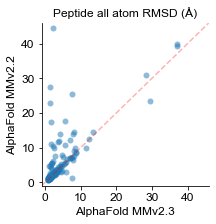

In [11]:
# make a scatterplot to see how the same DMI type is predicted with different accuracy or AlphaFold metrics

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(df['RMSD_all_atom_peptide_run48'], df['RMSD_all_atom_peptide_run37'], alpha=0.5,linewidths=0)
ax.axline([0,0],[1,1],linestyle='--',color='red',alpha=0.3)
# modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=5, y_major_multiple=10, y_minor_multiple=5)
plt.ylim([-1,46])
plt.xlim([-1,46])
plt.xticks(fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)

plt.title('Peptide all atom RMSD (Å)',fontsize=global_fontsize)
plt.ylabel('AlphaFold MMv2.2', fontsize=global_fontsize)
plt.xlabel('AlphaFold MMv2.3', fontsize=global_fontsize)

plt.savefig(f'{save_path}all_atom_RMSD_peptide_MMv2.2_MMv2.3.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}all_atom_RMSD_peptide_MMv2.2_MMv2.3.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')

In [9]:
print(f"degree of freedom: {len(df['RMSD_all_atom_peptide_run37'])-1}\n{sp.wilcoxon(df['RMSD_all_atom_peptide_run37'],df['RMSD_all_atom_peptide_run48'])}")

degree of freedom: 135
WilcoxonResult(statistic=2413.0, pvalue=1.0796824594264182e-06)


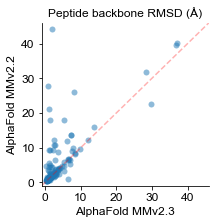

In [12]:
# make a scatterplot to see how the same DMI type is predicted with different accuracy or AlphaFold metrics

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(df['RMSD_backbone_peptide_run48'], df['RMSD_backbone_peptide_run37'], alpha=0.5,linewidths=0)
ax.axline([0,0],[1,1],linestyle='--',color='red',alpha=0.3)
# modify_ticks_and_labels(ax, x_major_multiple=10, x_minor_multiple=5, y_major_multiple=10, y_minor_multiple=5)
plt.ylim([-1,46])
plt.xlim([-1,46])
plt.xticks(fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)

plt.title('Peptide backbone RMSD (Å)',fontsize=global_fontsize)
plt.ylabel('AlphaFold MMv2.2', fontsize=global_fontsize)
plt.xlabel('AlphaFold MMv2.3', fontsize=global_fontsize)

plt.savefig(f'{save_path}backbone_RMSD_peptide_MMv2.2_MMv2.3.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}backbone_RMSD_peptide_MMv2.2_MMv2.3.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')

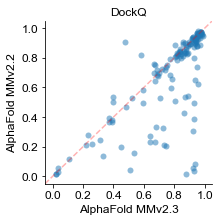

In [13]:
# make a scatterplot to see how the same DMI type is predicted with different accuracy or AlphaFold metrics

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(df['DockQ_run48'], df['DockQ_run37'], alpha=0.5,linewidths=0)
ax.axline([0,0],[1,1],linestyle='--',color='red',alpha=0.3)
modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2)
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])
plt.xticks(fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)

plt.title('DockQ',fontsize=global_fontsize)
plt.ylabel('AlphaFold MMv2.2', fontsize=global_fontsize)
plt.xlabel('AlphaFold MMv2.3', fontsize=global_fontsize)

plt.savefig(f'{save_path}DockQ_MMv2.2_MMv2.3.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}DockQ_MMv2.2_MMv2.3.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')

In [10]:
print(f"degree of freedom: {len(df['RMSD_all_atom_peptide_run37'])-1}\n{sp.wilcoxon(df['DockQ_run37'],df['DockQ_run48'])}")

degree of freedom: 135
WilcoxonResult(statistic=2160.0, pvalue=1.544141525705221e-07)


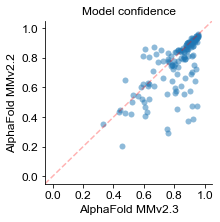

In [14]:
# make a scatterplot to see how the same DMI type is predicted with different accuracy or AlphaFold metrics

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(df['model_confidence_run48'], df['model_confidence_run37'], alpha=0.5,linewidths=0)
ax.axline([0,0],[1,1],linestyle='--',color='red',alpha=0.3)
modify_ticks_and_labels(ax, x_major_multiple=0.2, x_minor_multiple=0.2)
plt.ylim([-0.05,1.05])
plt.xlim([-0.05,1.05])
plt.xticks(fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)

plt.title('Model confidence',fontsize=global_fontsize)
plt.ylabel('AlphaFold MMv2.2', fontsize=global_fontsize)
plt.xlabel('AlphaFold MMv2.3', fontsize=global_fontsize)

plt.savefig(f'{save_path}model_confidence_MMv2.2_MMv2.3.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}model_confidence_MMv2.2_MMv2.3.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')

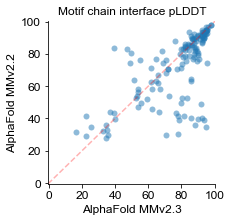

In [15]:
# make a scatterplot to see how the same DMI type is predicted with different accuracy or AlphaFold metrics

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(df['chainB_intf_avg_plddt_run48'], df['chainB_intf_avg_plddt_run37'], alpha=0.5,linewidths=0)
ax.axline([0,0],[1,1],linestyle='--',color='red',alpha=0.3)
modify_ticks_and_labels(ax, x_major_multiple=20, x_minor_multiple=20)
plt.ylim([-0.5,100.5])
plt.xlim([-0.5,100.5])
plt.xticks(fontsize=global_fontsize)
plt.yticks(fontsize=global_fontsize)

plt.title('Motif chain interface pLDDT',fontsize=global_fontsize)
plt.ylabel('AlphaFold MMv2.2', fontsize=global_fontsize)
plt.xlabel('AlphaFold MMv2.3', fontsize=global_fontsize)

plt.savefig(f'{save_path}motif_chain_interface_plddt_MMv2.2_MMv2.3.pdf',
           transparent=True,bbox_inches='tight')
plt.savefig(f'{save_path}motif_chain_interface_plddt_MMv2.2_MMv2.3.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')